In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [9]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate, plot_marginalised_dists, TrainUtil
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float().to(device)
X1_tensor = torch.tensor(X1).float().to(device)
X_prior_tensor = torch.tensor(X_prior).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fe83d373588>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fe83d38b390>)

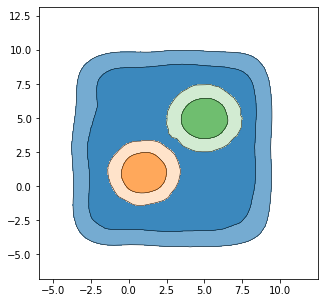

In [6]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [27]:
activation_fs = [F.relu, F.elu, F.leaky_relu, torch.tanh, torch.sigmoid]
activation_names = ["relu", "elu", "leaky relu", "tanh", "sigmoid"]
tension = TensionNet1(2)

In [28]:
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)

train_utils_R = []
for i, act_f in enumerate(activation_fs):
    net_act_f = copy.deepcopy(tension)
    net_act_f.activation_f = act_f
    optimizer = optim.SGD(net_act_f.parameters(), lr=0.0005)
    train_util = TrainUtil(net_act_f, optimizer, criterion, device)
    train_util.train(X0, X1, X_prior)
    
    train_utils_R.append(train_util)

Text(0.5, 0.98, 'Bayes Factor')

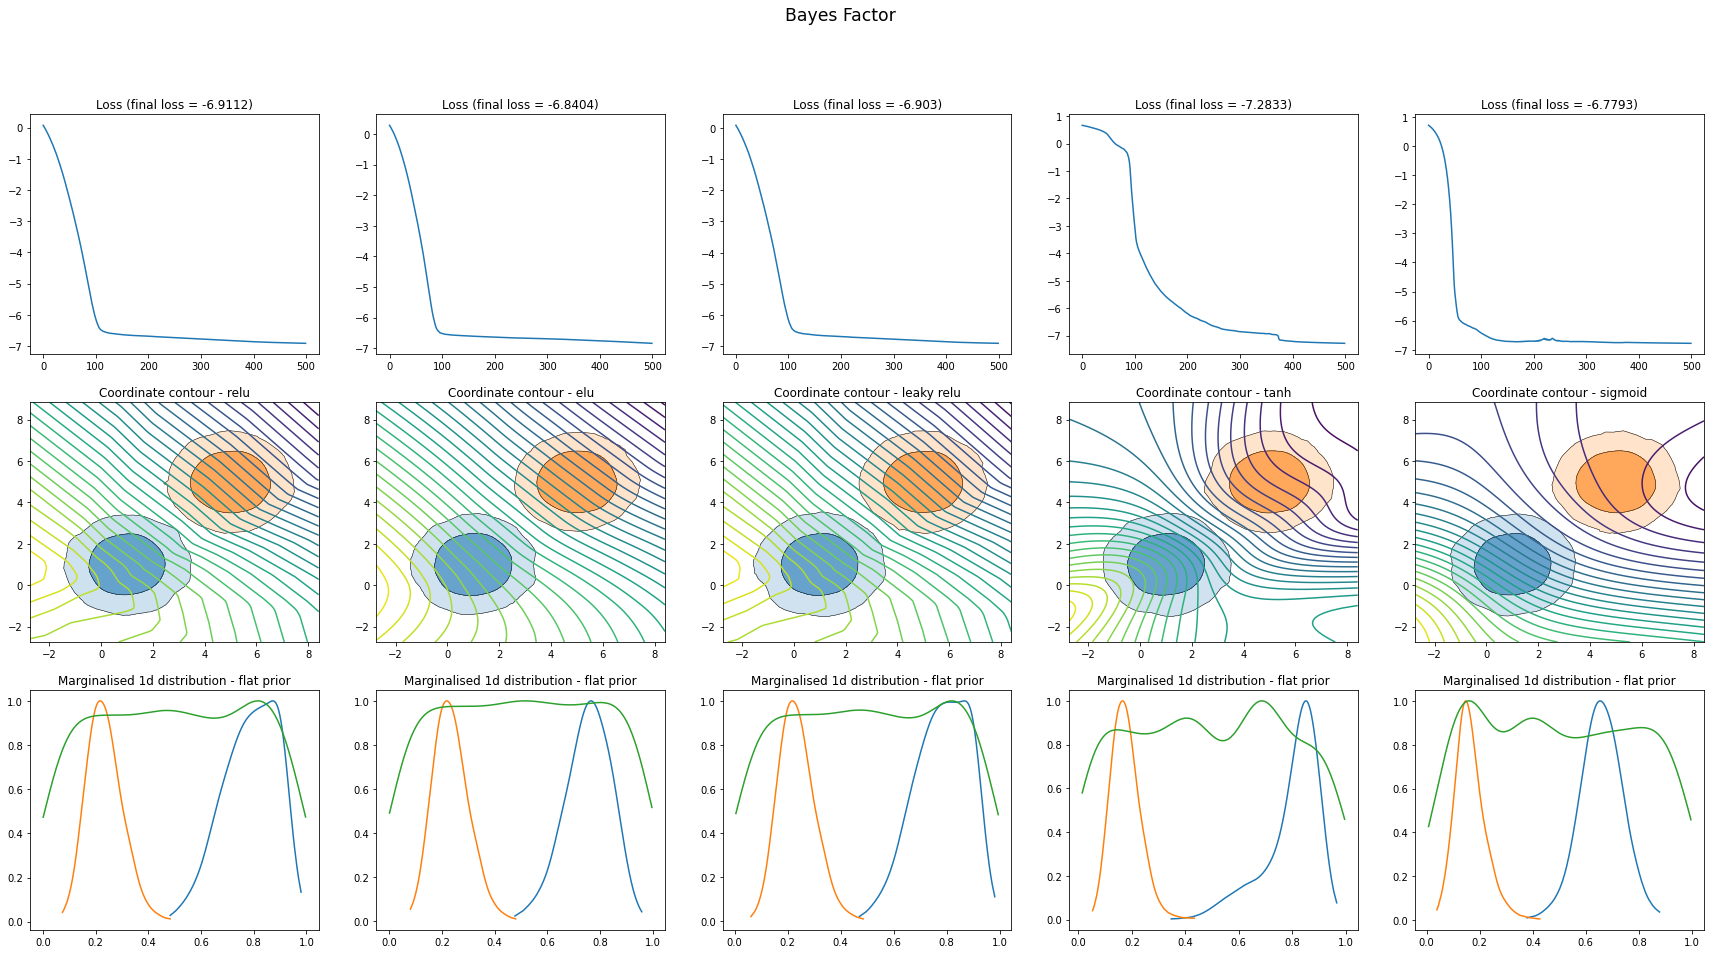

In [29]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    train_utils_R[i].plot_loss(axs[0, i])
    train_utils_R[i].visualise_coordinate(axs[1, i])
    train_utils_R[i].plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Coordinate contour - {activation_names[i]}")

fig.suptitle("Bayes Factor", size="xx-large")

In [36]:
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)

train_utils_S = []
for i, act_f in enumerate(activation_fs):
    net_act_f = copy.deepcopy(tension)
    net_act_f.activation_f = act_f
    optimizer = optim.SGD(net_act_f.parameters(), lr=0.0005)
    train_util = TrainUtil(net_act_f, optimizer, criterion, device)
    train_util.train(X0, X1, X_prior)
    
    train_utils_S.append(train_util)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 0.98, 'Suspiciousness')

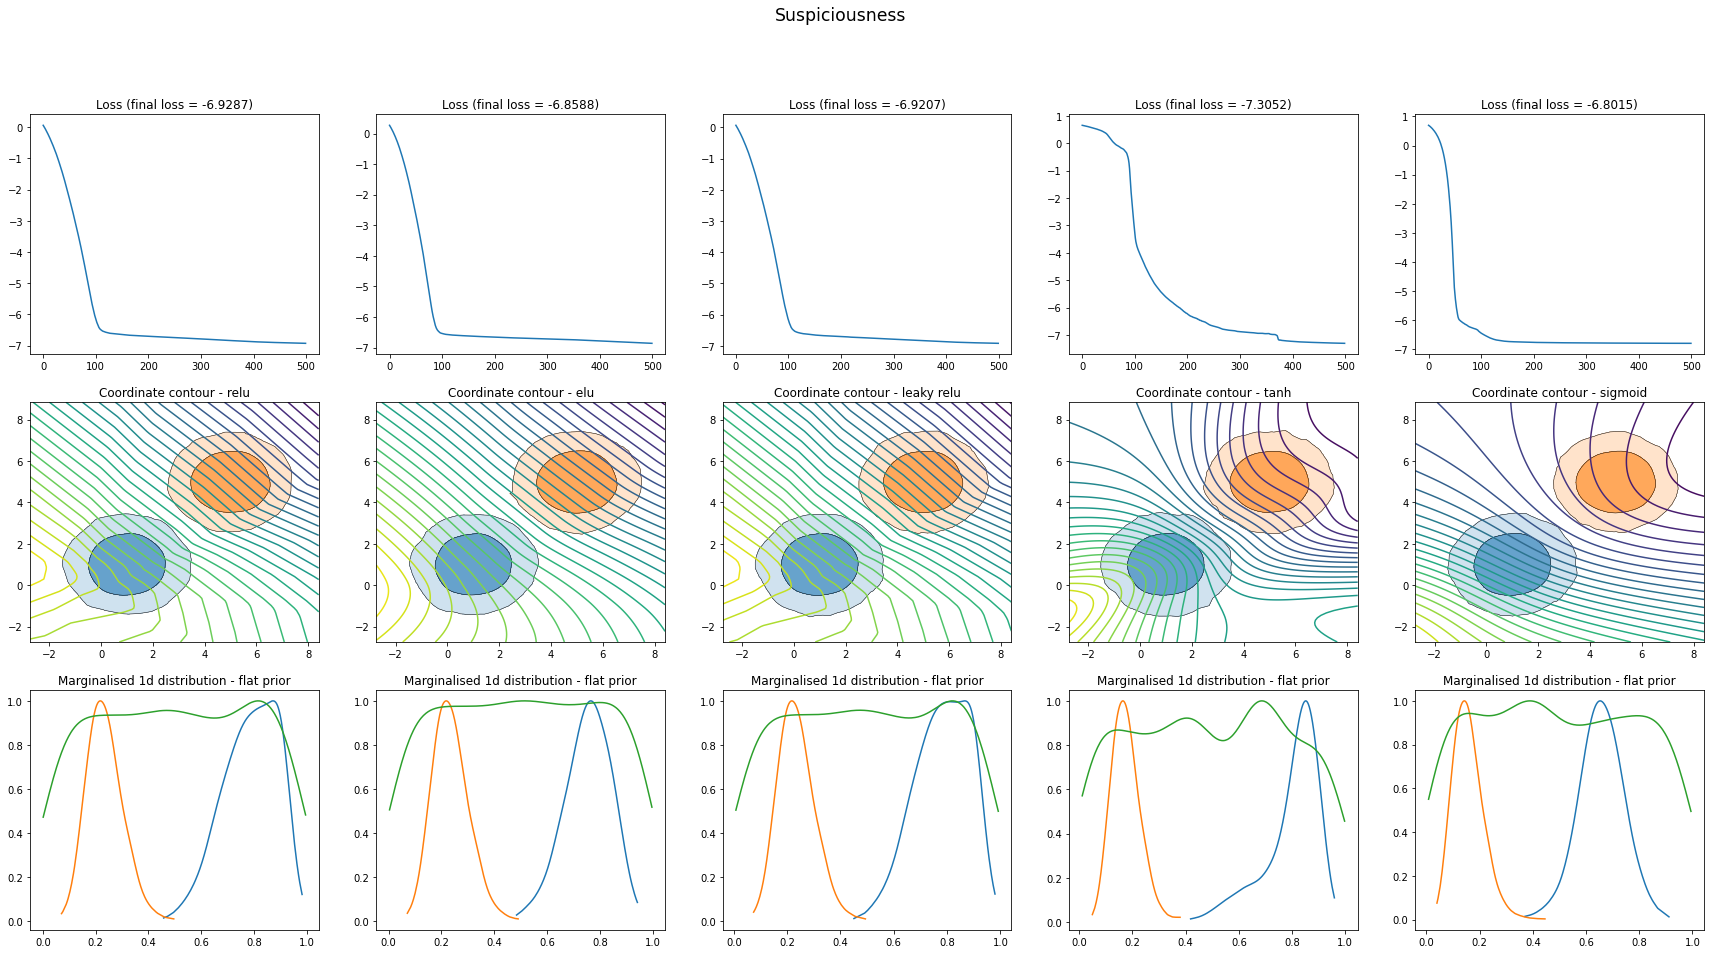

In [37]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    train_utils_S[i].plot_loss(axs[0, i])
    train_utils_S[i].visualise_coordinate(axs[1, i])
    train_utils_S[i].plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Coordinate contour - {activation_names[i]}")

fig.suptitle("Suspiciousness", size="xx-large")

In [38]:
X0_c, X1_c, X_prior_c = curved_data()
X0_c_tensor = torch.tensor(X0_c).float().to(device)
X1_c_tensor = torch.tensor(X1_c).float().to(device)
X_prior_c_tensor = torch.tensor(X_prior_c).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fe7cc6909b0>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fe7cc03a9e8>)

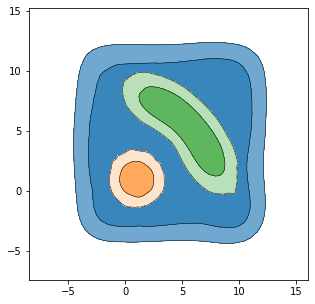

In [39]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior_c[:, 0], X_prior_c[:, 1])
kde_contour_plot_2d(axs, X0_c[:, 0], X0_c[:, 1])
kde_contour_plot_2d(axs, X1_c[:, 0], X1_c[:, 1])

In [54]:
tension = TensionNet1(2)

In [55]:
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)

train_utils_R_c = []
for i, act_f in enumerate(activation_fs):
    net_act_f = copy.deepcopy(tension)
    net_act_f.activation_f = act_f
    optimizer = optim.SGD(net_act_f.parameters(), lr=0.0005)
    train_util = TrainUtil(net_act_f, optimizer, criterion, device)
    train_util.train(X0_c, X1_c, X_prior_c, n_iter=1000)
    
    train_utils_R_c.append(train_util)

Text(0.5, 0.98, 'Bayes Factor')

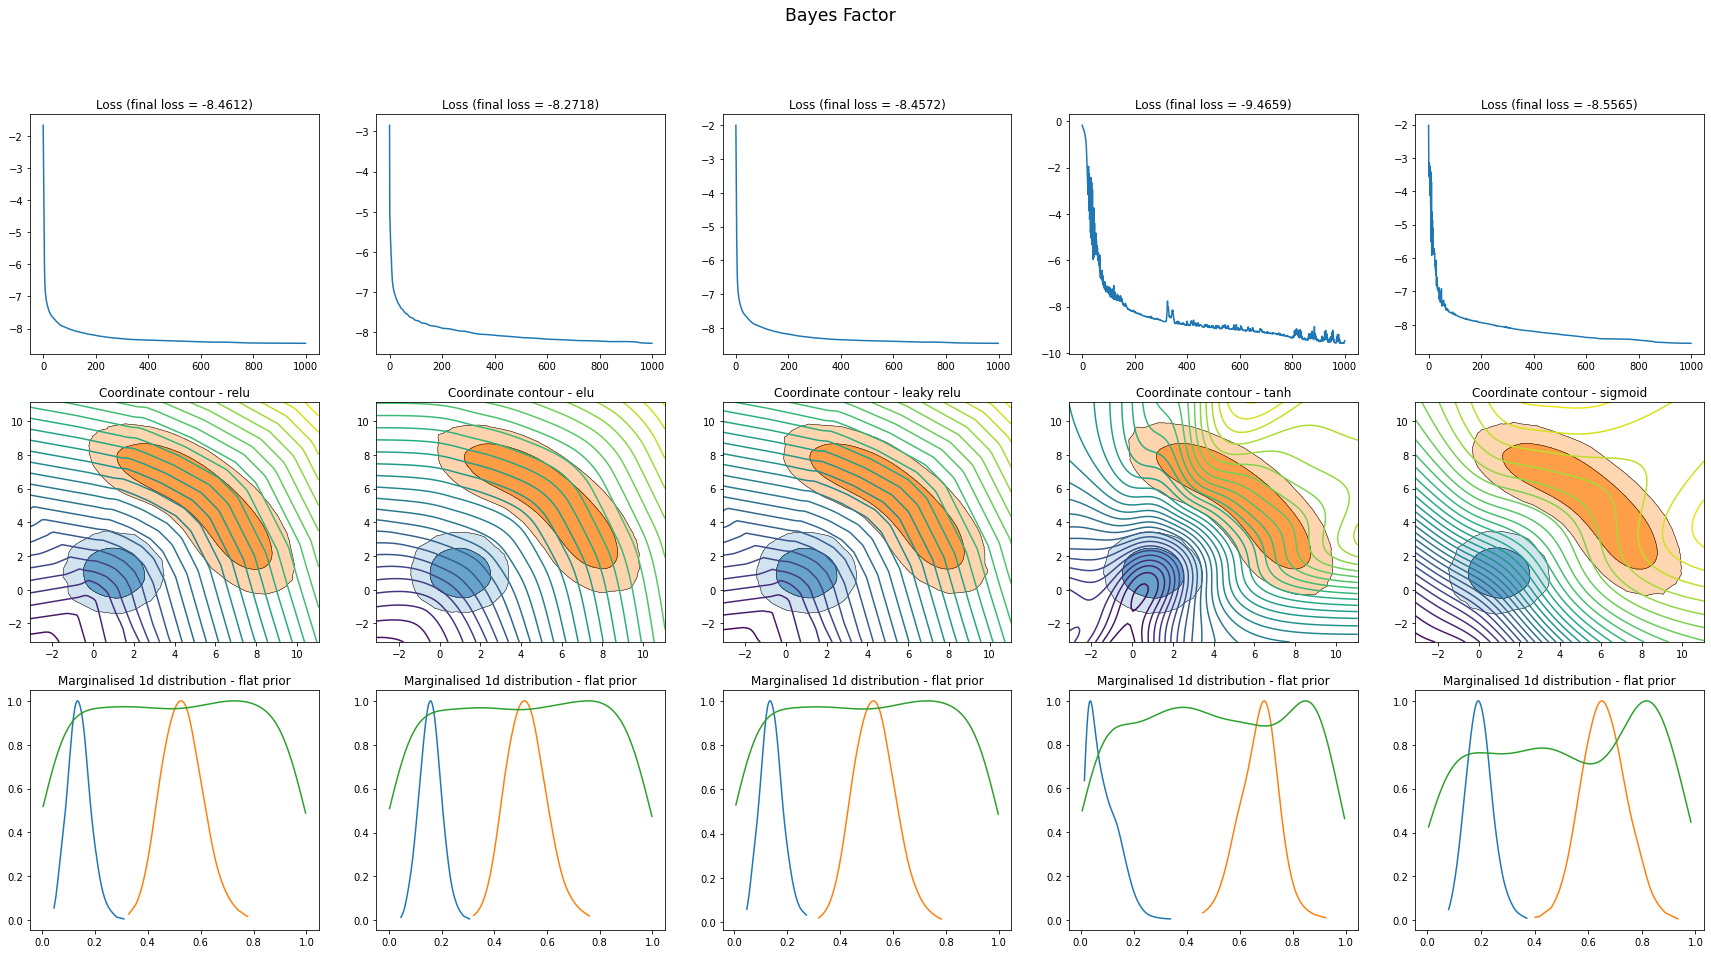

In [56]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    train_utils_R_c[i].plot_loss(axs[0, i])
    train_utils_R_c[i].visualise_coordinate(axs[1, i])
    train_utils_R_c[i].plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Coordinate contour - {activation_names[i]}")

fig.suptitle("Bayes Factor", size="xx-large")

In [57]:
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)

train_utils_S_c = []
for i, act_f in enumerate(activation_fs):
    net_act_f = copy.deepcopy(tension)
    net_act_f.activation_f = act_f
    optimizer = optim.SGD(net_act_f.parameters(), lr=0.0005)
    train_util = TrainUtil(net_act_f, optimizer, criterion, device)
    train_util.train(X0_c, X1_c, X_prior_c, n_iter=1000)
    
    train_utils_S_c.append(train_util)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 0.98, 'Suspiciousness')

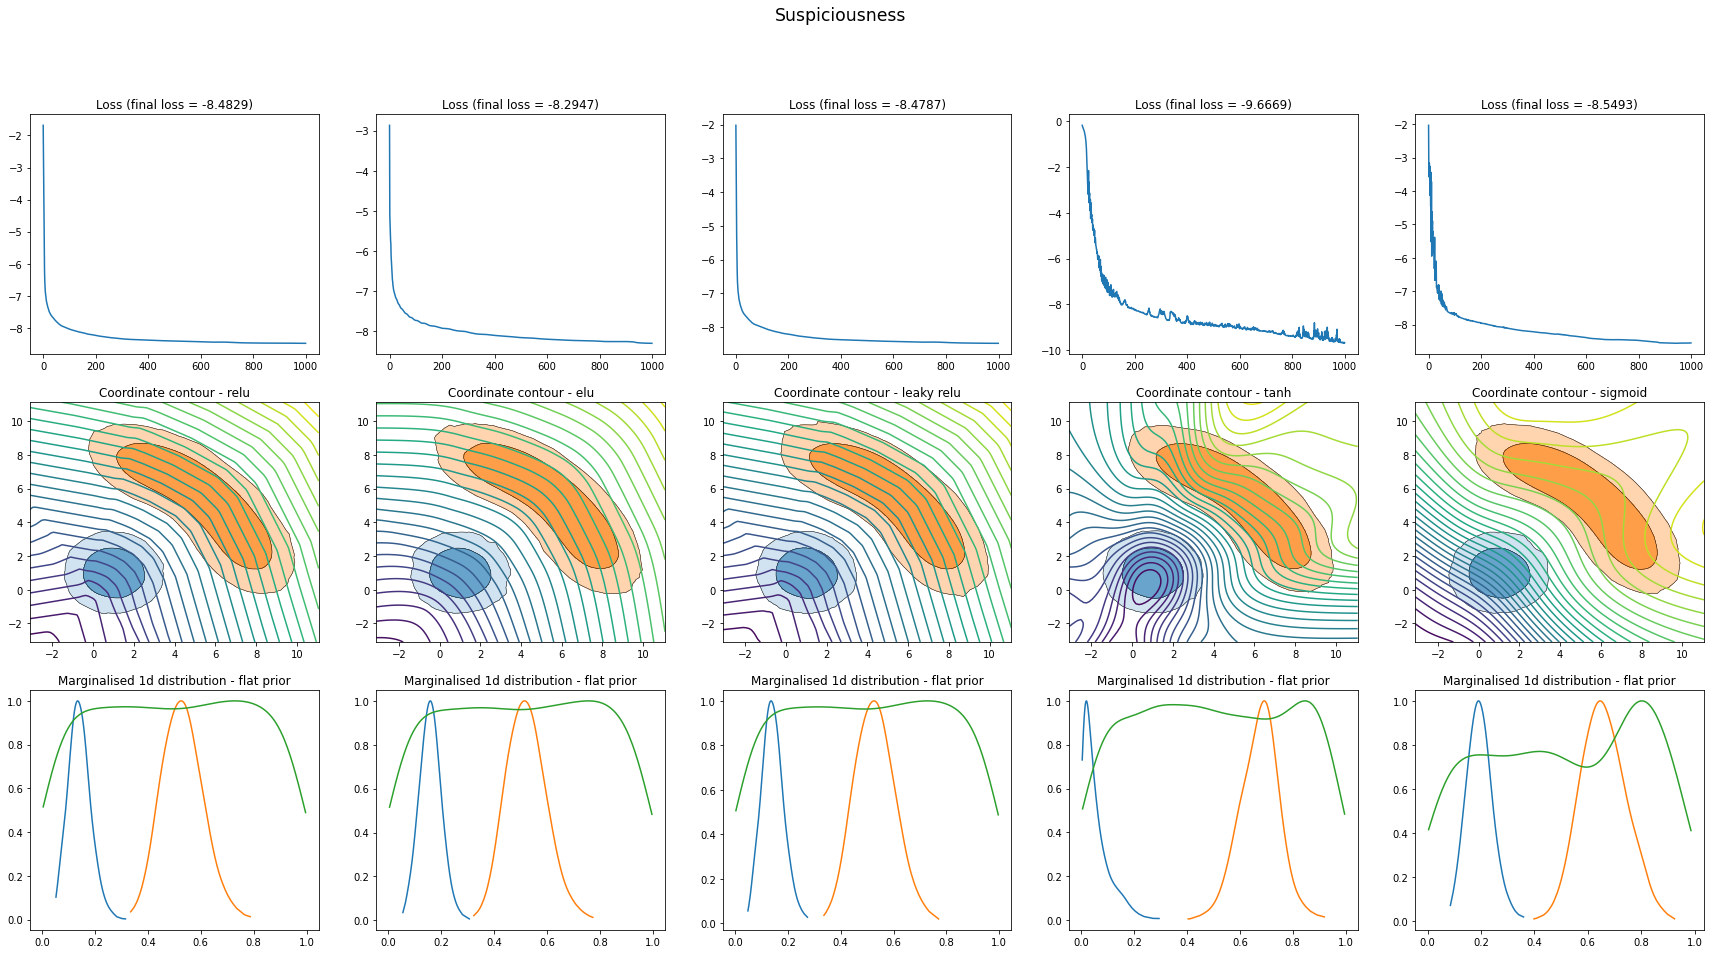

In [58]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    train_utils_S_c[i].plot_loss(axs[0, i])
    train_utils_S_c[i].visualise_coordinate(axs[1, i])
    train_utils_S_c[i].plot_marginalised_dists(axs[2, i], flat_prior=True)
    axs[1, i].set_title(f"Coordinate contour - {activation_names[i]}")

fig.suptitle("Suspiciousness", size="xx-large")